In [0]:
# https://iamtrask.github.io/2015/11/15/anyone-can-code-lstm/
# https://towardsdatascience.com/only-numpy-vanilla-recurrent-neural-network-back-propagation-practice-math-956fbea32704
# https://www.analyticsvidhya.com/blog/2017/12/introduction-to-recurrent-neural-networks/
import copy, numpy as np
import matplotlib.pyplot as pl
np.random.seed(0)

Error:[4.17131615]
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 0 1 0 1 0]
63 + 43 = 0
------------
Error:[3.86712001]
Pred:[0 0 0 0 0 1 0 1]
True:[1 0 0 0 0 1 1 1]
112 + 23 = 5
------------
Error:[3.8355734]
Pred:[0 1 1 1 1 1 1 1]
True:[0 1 0 1 0 1 1 1]
61 + 26 = 127
------------
Error:[3.60659258]
Pred:[1 1 0 0 1 1 0 1]
True:[1 1 0 1 1 1 0 1]
118 + 103 = 205
------------
Error:[2.91270205]
Pred:[0 0 1 1 1 1 0 1]
True:[0 0 1 1 1 0 1 1]
22 + 37 = 61
------------
Error:[2.07111854]
Pred:[1 0 1 0 1 1 0 1]
True:[1 0 1 0 1 1 0 1]
55 + 118 = 173
------------
Error:[1.27074167]
Pred:[1 1 1 1 0 1 1 0]
True:[1 1 1 1 0 1 1 0]
120 + 126 = 246
------------
Error:[0.79211303]
Pred:[0 1 0 1 1 0 1 1]
True:[0 1 0 1 1 0 1 1]
39 + 52 = 91
------------
Error:[0.45882912]
Pred:[1 1 0 1 0 1 0 0]
True:[1 1 0 1 0 1 0 0]
96 + 116 = 212
------------
Error:[0.47946579]
Pred:[0 0 1 0 0 1 1 1]
True:[0 0 1 0 0 1 1 1]
1 + 38 = 39
------------


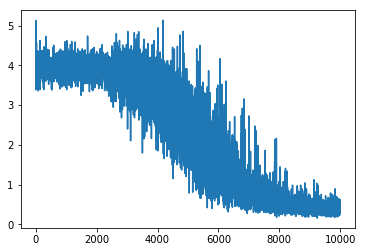

In [0]:
# compute sigmoid nonlinearity
def sigmoid(x):
  output = 1/(1+np.exp(-x))
  return output
# convert output of sigmoid function to its derivative
def sigmoid_output_to_derivative(output):
  return output*(1-output)

#convert binary to int
def binary2int(binary):
  out = 0
  for index,x in enumerate(reversed(binary)):
      out += x*pow(2,index)
  return out

# training dataset generation
int2binary = {}
binary_dim = 8

largest_number = pow(2,binary_dim)
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

for i in range(largest_number):
  int2binary[i] = binary[i]

# input variables
alpha = 0.1
input_dim = 2
hidden_dim = 16
output_dim = 1

# initialize neural network weights
synapse_0 = 2*np.random.random((input_dim,hidden_dim)) - 1
synapse_1 = 2*np.random.random((hidden_dim,output_dim)) - 1
synapse_h = 2*np.random.random((hidden_dim,hidden_dim)) - 1

synapse_0_update = np.zeros_like(synapse_0)
synapse_1_update = np.zeros_like(synapse_1)
synapse_h_update = np.zeros_like(synapse_h)

error_history = list()

# training logic
for j in range(10000):
  # generate a simple addition problem (a + b = c)
  a_int = np.random.randint(largest_number/2) # int version
  a = int2binary[a_int] # binary encoding

  b_int = np.random.randint(largest_number/2) # int version
  b = int2binary[b_int] # binary encoding

  # true answer
  c_int = a_int + b_int
  c = int2binary[c_int]
  
  # where we'll store our best guess (binary encoded)
  d = np.zeros_like(c)
  overallError = 0
  
  layer_2_deltas = list()
  layer_1_values = list()
  layer_1_values.append(np.zeros(hidden_dim))
  
  # moving along the positions in the binary encoding
  for position in range(binary_dim):
    # generate input and output
    X = np.array([[a[binary_dim - position - 1],b[binary_dim - position - 1]]])
    y = np.array([[c[binary_dim - position - 1]]])
    
    # hidden layer (input ~+ prev_hidden)
    layer_1 = sigmoid(np.dot(X,synapse_0) + np.dot(layer_1_values[-1],synapse_h))
    
    # output layer (new binary representation)
    layer_2 = sigmoid(np.dot(layer_1,synapse_1))
    
    # did we miss?... if so, by how much?
    layer_2_error = y - layer_2
    layer_2_deltas.append((layer_2_error)*sigmoid_output_to_derivative(layer_2))
    overallError += np.abs(layer_2_error[0])
    
    # decode estimate so we can print it out
    d[binary_dim - position - 1] = np.round(layer_2[0][0])
    
    # store hidden layer so we can use it in the next timestep
    layer_1_values.append(layer_1)
    
  future_layer_1_delta = np.zeros(hidden_dim)

  for position in range(binary_dim):
    X = np.array([[a[position],b[position]]])
    layer_1 = layer_1_values[-position-1]
    prev_layer_1 = layer_1_values[-position-2]
    
    # error at output layer
    layer_2_delta = layer_2_deltas[-position-1]
    
    # error at hidden layer
    layer_1_delta = (future_layer_1_delta.dot(synapse_h.T) + layer_2_delta.dot(synapse_1.T)) * sigmoid_output_to_derivative(layer_1)
    
    # let's update all our weights so we can try again
    synapse_1_update += np.atleast_2d(layer_1).T.dot(layer_2_delta)
    synapse_h_update += np.atleast_2d(prev_layer_1).T.dot(layer_1_delta)
    synapse_0_update += X.T.dot(layer_1_delta)
    
    future_layer_1_delta = layer_1_delta

  synapse_0 += synapse_0_update * alpha
  synapse_1 += synapse_1_update * alpha
  synapse_h += synapse_h_update * alpha   

  synapse_0_update *= 0
  synapse_1_update *= 0
  synapse_h_update *= 0

  # print out progress
  error_history.append(overallError)
  
  if(j % 1000 == 0):
    print("Error:" + str(overallError))
    print("Pred:" + str(d))
    print("True:" + str(c))

    print(str(a_int) + " + " + str(b_int) + " = " + str(binary2int(d)))
    print("------------")
    
_ = pl.plot(error_history)

In [0]:
a = [0, 0, 1, 0, 0, 1, 0, 1]
b = [1, 0, 1, 0, 1, 0, 1, 1]

c = binary2int(a) + binary2int(b)
c = int2binary[c]
print('True: ', c)

#Prediction
d = np.zeros(binary_dim, dtype=np.uint8)
layer_1_values = list()
layer_1_values.append(np.zeros(hidden_dim))

for position in range(binary_dim):
  X = np.array([[a[binary_dim - position - 1], b[binary_dim - position - 1]]])
  
  layer_1 = sigmoid(np.dot(X, synapse_0) + np.dot(layer_1_values[-1], synapse_h))
  layer_2 = sigmoid(np.dot(layer_1, synapse_1))
  layer_1_values.append(copy.deepcopy(layer_1))
  
  d[binary_dim - position - 1] = np.round(layer_2[0][0])
  
print('Pred: ', d)

True:  [1 1 0 1 0 0 0 0]
Pred:  [1 1 0 1 0 0 0 0]


A:     [0, 1, 0, 0, 0, 0, 0, 1]
B:     [0, 0, 0, 0, 1, 0, 0, 1]
---------------------
True:  [0 1 0 0 1 0 1 0]
Pred:  [0 1 0 0 1 0 1 0]


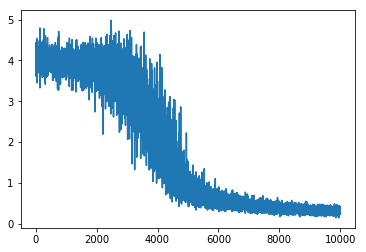

In [0]:
# Practice
def bin2int(x):
  res = 0
  for idx, i in enumerate(reversed(x)):
    res += i * 2 ** idx
  return res

def int2bin(x):
  return np.unpackbits(np.array([x], dtype=np.uint8))

def sigmoid(x):
  return 1/(1 + np.exp(-x))

def sigmoid_derivative(o):
  return o*(1 - o)
  
# RNN
i_dim = 2
h_dim = 16
o_dim = 1

syn_i = 2*np.random.random((i_dim, h_dim)) - 1
syn_h = 2*np.random.random((h_dim, h_dim)) - 1
syn_o = 2*np.random.random((h_dim, o_dim)) - 1

syn_i_upd = np.zeros_like(syn_i)
syn_h_upd = np.zeros_like(syn_h)
syn_o_upd = np.zeros_like(syn_o)

# Learning
alpha = 0.1
n_epochs = 10000
max_val = 255
bin_dim = 8
err_epochs = list()

for i in range(n_epochs):
  a_int = np.random.randint(max_val/i_dim) # n = 0:85
  a = int2bin(a_int)
  b_int = np.random.randint(max_val/i_dim) # n = 0:85
  b = int2bin(b_int)
  
  d_int = a_int + b_int
  d = int2bin(d_int)
  
  lo_deltas = list()
  lh_values = list()
  lh_values.append(np.zeros(h_dim))
  
  sum_err = 0
  for i in range(bin_dim):
    X = np.array([[a[bin_dim-i-1], b[bin_dim-i-1]]])
    Y = np.array([[d[bin_dim-i-1]]]).T
     
    lh = sigmoid(np.dot(X, syn_i) + np.dot(lh_values[-1], syn_h))
    lo = sigmoid(np.dot(lh, syn_o))
    
    lo_err = Y - lo
    sum_err += np.abs(lo_err[0])
    
    lh_values.append(lh)
    lo_deltas.append(lo_err*sigmoid_derivative(lo))  
  err_epochs.append(np.abs(sum_err))
  
  lh_nxt_delta = np.zeros(h_dim)
  for i in range(bin_dim):
    X = np.array([[a[i], b[i]]])
    lh = lh_values[-i - 1]
    lh_pre = lh_values[-i - 2]
    lo_delta = lo_deltas[-i - 1]
    lh_delta = (np.dot(lh_nxt_delta, syn_h.T) + np.dot(lo_delta, syn_o.T))*sigmoid_derivative(lh)
    
    syn_i_upd += np.dot(X.T, lh_delta)
    syn_h_upd += np.dot(np.atleast_2d(lh_pre).T, lh_delta)
    syn_o_upd += np.dot(np.atleast_2d(lh).T, lo_delta)
    
    lh_nxt_delta = lh_delta
    
  syn_i += syn_i_upd*alpha
  syn_h += syn_h_upd*alpha
  syn_o += syn_o_upd*alpha
  
  syn_i_upd *= 0
  syn_h_upd *= 0
  syn_o_upd *= 0
  
pl.plot(err_epochs)

# Predict
a = [0, 1, 0, 0, 0, 0, 0, 1]
b = [0, 0, 0, 0, 1, 0, 0, 1]

d = int2bin(bin2int(a) + bin2int(b))

lh_values = list()
lh_values.append(np.zeros(h_dim)) 
pred = np.zeros(bin_dim, dtype=np.uint8)

for i in range(bin_dim):
  X = [a[bin_dim-i-1], b[bin_dim-i-1]]
  Y = [d[bin_dim-i-1]]

  lh = sigmoid(np.dot(X, syn_i) + np.dot(lh_values[-1], syn_h))
  lo = sigmoid(np.dot(lh, syn_o))
  
  lh_values.append(lh)
  pred[bin_dim - i - 1] = np.round(lo[0])
  
print('A:    ', a)
print('B:    ', b)
print('---------------------')
print('True: ', d)
print('Pred: ', pred)